In [1]:


import pandas as pd
import numpy as np 

df = pd.read_csv("clean_data.csv")
df = df.drop(["bmi_categories"], axis=1)
df 




,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,0,northwest,10600.54830
1333,18,female,31.920,0,0,northeast,2205.98080
1334,18,female,36.850,0,0,southeast,1629.83350
1335,21,female,25.800,0,0,southwest,2007.94500


/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.066e+08, tolerance: 1.290e+06
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.165e+08, tolerance: 2.910e+06
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

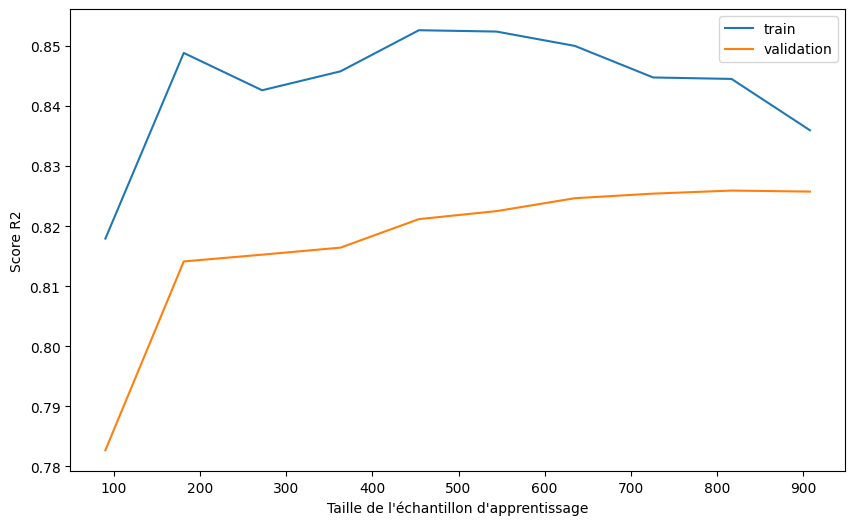

In [2]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.compose import ColumnTransformer 
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

# selection des features et de la cible
X = df.drop('charges', axis=1)
y = df.charges

# Création du train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)


# Sélection des variables numériques
num_col = list(X.select_dtypes(include=[float,int]).columns)
# Sélection des variables catégorielles
cat_col = list(X.select_dtypes(include=[object]).columns)


# pipeline pour les valeurs numériques
# cela permet de créer une succession d'étapes (ici il n'y en a qu'une)
my_num_pipe = make_pipeline(PolynomialFeatures(2), StandardScaler())
# Créer un pipeline pour les variables catégorielles
categorical_pipeline = make_pipeline(OneHotEncoder())




preprocessing = ColumnTransformer([
    ("numeric", my_num_pipe, num_col),
    ("categorical", categorical_pipeline, cat_col)
])

# Créer le pipeline complet avec préprocesseur et modèle
my_pipe_elasticnet = make_pipeline(
    preprocessing,
    ElasticNet(alpha=1e-05, l1_ratio=1)
)




# # ColumnTransformer permet de faire des opérations sur des sélections de colonnes
# preprocessing = ColumnTransformer([
#     ("one_hot", OneHotEncoder(), cat_col),
#     ("scaling", my_num_pipe, num_col)
# ])


# Learning curve
N, train_score, val_score = learning_curve(my_pipe_elasticnet, X_train, y_train, 
                                           train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('Taille de l\'échantillon d\'apprentissage')
plt.ylabel('Score R2')
plt.legend()
plt.show()



In [3]:
# Appliquez le pipeline sur les données d'entraînement et de test
# X_train_transformed = preprocessing.fit_transform(X_train)
# X_train_transformed



In [4]:
# # Supposez que X_train_transformed soit une matrice NumPy résultante de la transformation
# # Appliquer le ColumnTransformer sur les données d'entraînement
# X_train_transformed = preprocessing.fit_transform(X_train)

# # Obtenez les noms de colonnes après la transformation
# all_columns = preprocessing.transformers_[0][1].get_feature_names_out(cat_col).tolist() + num_col

# # Créez un DataFrame pandas à partir des données transformées et des noms de colonnes
# X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_columns)

# # Affichez le DataFrame
# print(X_train_transformed_df.head())



In [5]:
# DUMMY REGRESSOR (ne prend pas en compte les variables, prédit la moyenne de chaque valeur Y)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
print(f"regression dummy : {dummy_regr.score(X_test, y_test)}")


regression dummy : -0.0020162626112618653


In [6]:
#Code qui marche po

import numpy as np

# Filtrage des données pour les fumeurs et non-fumeurs
smoker_yes = X_train[X_train['smoker'] == 'yes']
smoker_no = X_train[X_train['smoker'] == 'no']

# Régression linéaire pour les fumeurs
regression_yes = LinearRegression()
regression_yes.fit(smoker_yes[['bmi']], y_train.loc[smoker_yes.index])
predicted_yes = regression_yes.predict(smoker_yes[['bmi']])
residuals_yes = y_train.loc[smoker_yes.index] - predicted_yes

# Identifier les points éloignés pour les fumeurs
threshold = 18000  # Seuil pour identifier les points éloignés
outliers_yes = np.abs(residuals_yes) > threshold

# Régression linéaire pour les non-fumeurs
regression_no = LinearRegression()
regression_no.fit(smoker_no[['bmi']], y_train.loc[smoker_no.index])
predicted_no = regression_no.predict(smoker_no[['bmi']])
residuals_no = y_train.loc[smoker_no.index] - predicted_no

# Identifier les points éloignés pour les non-fumeurs
outliers_no = np.abs(residuals_no) > threshold

# Tracé des points pour les fumeurs et non-fumeurs avec les points éloignés en vert
plt.scatter(smoker_yes['bmi'][~outliers_yes], y_train[smoker_yes.index][~outliers_yes], color='blue', label='Smoker: Yes')
plt.scatter(smoker_yes['bmi'][outliers_yes], y_train[smoker_yes.index][outliers_yes], color='yellow', label='Outliers: Yes')

plt.scatter(smoker_no['bmi'][~outliers_no], y_train[smoker_no.index][~outliers_no], color='red', label='Smoker: No')
plt.scatter(smoker_no['bmi'][outliers_no], y_train[smoker_no.index][outliers_no], color='green', label='Outliers: No')

# Régression linéaire pour les fumeurs et non-fumeurs
plt.plot(smoker_yes['bmi'], regression_yes.predict(smoker_yes[['bmi']]), color='black')
plt.plot(smoker_no['bmi'], regression_no.predict(smoker_no[['bmi']]), color='black')

# Définition des titres et des légendes
plt.title('Charges en fonction de BMI avec outliers en vert')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()

# Affichage du graphique
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
# REGRESSION LINEAIRE
import statsmodels.api as sm

# Appliquer le prétraitement sur X_train
X_train_preprocessed = preprocessing.fit_transform(X_train)

# Ajouter une colonne de constante
X_train_preprocessed = sm.add_constant(X_train_preprocessed)

# Modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_preprocessed).fit()

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance[0]

#display Cook's distances
print(cooks)

[7.14363110e-04 2.05017235e-03 6.21794599e-05 ... 6.74233560e-05
 1.94274439e-05 5.93338514e-05]


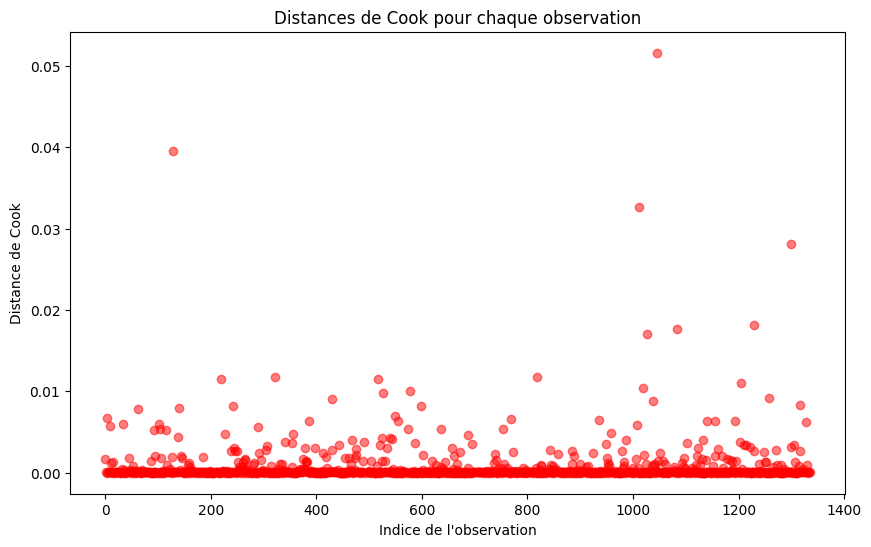

In [ ]:
import matplotlib.pyplot as plt

# Afficher les distances de Cook graphiquement
plt.figure(figsize=(10, 6))
plt.scatter(X_train.index, cooks, c='red', marker='o', alpha=0.5)
plt.title("Distances de Cook pour chaque observation")
plt.xlabel("Indice de l'observation")
plt.ylabel("Distance de Cook")
plt.show()

In [ ]:
my_pipe_lr[-1].coef_
# plus le coef est gros plus l'info est importante



NameError: name 'my_pipe_lr' is not defined

In [ ]:


# REGRESSION LASSO CV
my_pipe_lasso = make_pipeline(preprocessing, Lasso(alpha=9.91))
# Je fit sur les données
my_pipe_lasso.fit(X_train, y_train)
# le score
print(f"regression lasso : {my_pipe_lasso.score(X_test, y_test)}")





regression lasso : 0.901635378095105


In [ ]:


from sklearn.model_selection import GridSearchCV
param = {"lasso__alpha" : np.arange(0.01,10, 0.1)}

grid = GridSearchCV(my_pipe_lasso, param, cv=5)
grid.fit(X_train, y_train)



/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['...
       2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91, 3.01, 3.11, 3.21,
       3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91, 4.01, 4.11, 4.21, 4.31,
       4.41, 4.51, 4.61, 4.71, 4.81, 4.91, 5.01, 5.11, 5.21, 5.31, 5.41,
       5.51, 5.61, 5.71, 5.81, 5.91, 6.01, 6.11, 6.21, 6.31, 6.41, 6.51,
       6.61, 6.71, 6.81, 6.91, 7.01, 7.11, 7.21, 7.31, 7.41, 7.51, 7.61,
       7.71, 7.81, 7.91, 8.01, 8.11, 8.21, 8.31, 8.41, 8.51, 8.61, 8.71,
       8.81, 8.91, 9.01, 9.11, 9.21, 9.31, 9.41, 9.51, 9.61, 9.71, 9.81,
       9.91])})

In [ ]:


# REGRESSION ELASTICNETCV
my_pipe_elasticnet = make_pipeline(preprocessing, ElasticNet(alpha=0.01))
# Je fit sur les données
my_pipe_elasticnet.fit(X_train, y_train)
# le score
print(f"regression elasticnet : {my_pipe_elasticnet.score(X_test, y_test)}")



regression elasticnet : 0.9034863364016903


In [ ]:


from sklearn.model_selection import GridSearchCV
param = {"elasticnet__alpha" : np.arange(0.000001, 0.0001, 0.1)}

grid = GridSearchCV(my_pipe_elasticnet, param, cv=5)
grid.fit(X_train, y_train)



/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+10, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.139e+10, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Projets/machinelearning_assurance/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('polynomialfeatures',
                                                                                          PolynomialFeatures()),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('elasticnet', ElasticNet(alpha=0.01))]),
             param_grid={'elasticnet__alpha': array([1.e-06])})

In [ ]:
# REGRESSION RIDGE CV 
my_pipe_ridge = make_pipeline(preprocessing, Ridge())
# Je fit sur les données
my_pipe_ridge.fit(X_train, y_train)
# le score
print(f"regression ridge : {my_pipe_ridge.score(X_test, y_test)}")


regression ridge : 0.9012543194867233


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {"ridge__alpha" : np.arange(0.01,5, 0.1)}

grid = GridSearchCV(my_pipe_ridge, param, cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'ridge__alpha': 1.01}